In [1]:
from qpe import *

from numpy import cumsum

from time import time
from scipy.stats import gaussian_kde

from multiprocessing import Pool
from functools import partial

import spsa

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [158]:
def train_shots(dms, labels, n_layers, n_shots, n_copies=1, n_meas=0, method="Cobyla", w_ls=1e0, w_var=1e-4,
                x0=None, options={}, save_data=False, file_name=None, fvals=[], parallel=False):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
                
    n_pars_est = 2**n_meas
    n_pars_ans = (3*n_tot - 1)*n_layers + 2*n_tot # cry  
    
    d_diff = 2**(n_tot - n_meas)
    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]

    fval_cont = [0]

    # def fun(x):
    #     x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    #     U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    #     expecs = []
    #     sq_expecs = []
    #     for dm in dms_cop:
    #         counts_trans = measure_z_counts(U@dm@U.conj().T, n_shots)/n_shots*x_est
    #         expec = np.sum(counts_trans)
    #         sq_expec = np.sum(counts_trans*x_est)
    #         expecs.append(expec)
    #         sq_expecs.append(sq_expec)
    #     disps = array(sq_expecs) - array(expecs)**2
    #     f_ls = np.sum((array(expecs) - array(labels_train))**2)
    #     f_var = np.sum(disps)
    #     f = w_ls*f_ls + w_var*f_var
    #     fval_cont[0] = f
    #     return f
    
    # def fun(x):
    #     x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
    #     U = hea_cry_rzrx(n_tot, n_layers, x_ans)
    #     dms_cop_u = [U@dm@U.conj().T for dm in dms_cop]
    #     counts_list = []
    #     with Pool() as pool:
    #         counts_list = pool.map(partial(measure_z_counts, n_shots=n_shots), dms_cop_u)
    #     expecs = array(counts_list)*x_est/n_shots
    #     sq_expecs = expecs*x_est
    #     f_ls = np.sum((np.sum(expecs, axis=1) - array(labels_train))**2)
    #     f_var = np.sum(np.sum(sq_expecs, axis=1) - np.sum(expecs, axis=1)**2)
    #     f = w_ls*f_ls + w_var*f_var
    #     print("\t\tFunction value: %.8f" %f, end="\r")
    #     fval_cont[0] = f
    #     return f

    def fun_seq(x):
        """ Faster for N>8 """
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        U_dag = U.conj().T
        dms_cop_u = [U@dm@U_dag for dm in dms_cop]
        counts_list = array([measure_z_counts(dm, n_shots) for dm in dms_cop_u])
        expecs = counts_list*x_est/n_shots
        sq_expecs = np.sum(expecs*x_est, axis=1)
        expecs = np.sum(expecs, axis=1)
        f_ls = np.sum((expecs - array(labels_train))**2)
        f_var = np.sum(sq_expecs - expecs**2)
        f = w_ls*f_ls + w_var*f_var
        fval_cont[0] = f
        # fvals.append(fval_cont[0])
        # print("\t\tIteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return f
        
    def fun_par(x):
        """ Faster for N<8 """
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        U_dag = U.conj().T
        dms_cop_u = [U@dm@U_dag for dm in dms_cop]
        with Pool() as pool:
            counts_list = array(pool.map(partial(measure_z_counts, n_shots=n_shots), dms_cop_u))
        expecs = counts_list*x_est/n_shots
        sq_expecs = np.sum(expecs*x_est, axis=1)
        expecs = np.sum(expecs, axis=1)
        f_ls = np.sum((expecs - array(labels_train))**2)
        f_var = np.sum(sq_expecs - expecs**2)
        f = w_ls*f_ls + w_var*f_var
        fval_cont[0] = f
        # fvals.append(fval_cont[0])
        # print("\t\tIteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        return f
    
    if parallel==True:
        fun = fun_par
    else:
        fun = fun_seq
    
    if file_name is None and save_data == True:
        path = "/home/kardashin/Work/QPE/Results/Entanglement/Shots/"
        file_info = "c=%d-m=%d=l=%d-s=%d-w_ls=%f-w_var=%f-T=%d" %(n_copies, n_meas, n_layers, n_shots, w_ls, w_var, len(labels))
        # task_info = "-ent_rand_mixed"
        file_name = path + file_info #+ task_info 
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\tIteration: %d | Function value: %.8f" %(len(fvals), fval_cont[0]), end="\r")
        if save_data == True:
            np.save(file_name + "-pars", x)
            np.save(file_name + "-fvals", fvals)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(-10, 10)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 0.01*pi, n_pars_ans)
        x0_est = normal(0, 0.01, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)
    # optimization_result = spsa.minimize(fun, x0)
    
    return fvals, optimization_result

In [4]:
def estimate_shots(dms, labels, n_layers, pars, n_shots, n_copies=1, n_meas=0, n_est=1):
        
    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    U = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    dms_cop = [reduce(kron, [U@dm@U.conj().T]*n_copies) for dm in dms]
    
    preds = []
    errors = []
    for e in range(n_est):
        print("\t\tEstimation run: %d" %e, end="\r")
        preds_e = []
        errors_e = []
        for j in range(len(dms)):
            counts = measure_z_counts(dms_cop[j], n_shots)
            pred_j = np.sum(counts/n_shots*pars_est)
            error_j = (pred_j - labels[j])**2
            preds_e.append(pred_j)
            errors_e.append(error_j)
        preds.append(array(preds_e))
        errors.append(array(errors_e))
        
    return array(preds), array(errors)

In [5]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

### Settings

In [6]:
n_inp = 2
n_train = 1000
n_test = 10000
mixed = True
marks = "neg"

dms_train, labels_train = gen_even_ent_data(n_train, n_inp=n_inp, mixed=mixed, marks=marks)
dms_test, labels_test = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

In [8]:
n_shots_list = [100, 1000, 10000]

In [9]:
path = r"/home/kardashin/Work/QPE/Results/Entanglement/Shots/"
info = r"T=%d-w_ls=%.1f-w_var=%.4f" %(n_train, w_ls, w_var)
info += "-ent_rand_mixed"

In [10]:
np.save(path + info + "-labels_train", labels_train)
np.save(path + info + "-dms_train", dms_train)

#### 1 copy start

In [62]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_tot_1 = n_inp*n_copies_1
n_layers_1 = 2
n_shots = 1000

x0 = concatenate([normal(pi/2, 0.1, (3*n_tot_1 - 1)*n_layers_1 + 2*n_tot_1), normal(0, 1e-2, 2**n_meas_1)])
# x0 = concatenate([uniform(0, 2*pi, (3*n_tot_1 - 1)*n_layers_1 + 2*n_tot_1), uniform(-1, 1, 2**n_meas_1)])
# x0 = array(pars)

file_info = "c=%d-m=%d=l=%d-s=%d-w_ls=%.1f-w_var=%.4f-T=%d" %(n_copies_1, n_meas_1, n_layers_1, n_shots, w_ls, w_var, len(labels_train))
task_info = "-ent_rand_mixed"
file_name = path + file_info + task_info

time_start_1 = time()
fvals_1, result_1 = train_shots(dms_train, labels_train, n_layers_1, n_shots=n_shots, method=method, 
                                n_copies=n_copies_1, n_meas=n_meas_1, w_ls=w_ls, w_var=w_var, 
                                options=options, x0=x0, save_data=True, file_name=file_name)
time_finish_1 = time() - time_start_1
print("\n\nFinished in", time_finish_1)
print("Cost:", result_1.fun)
print(result_1.message)
pars_1 = result_1.x

		Iteration: 101 | Function value: 83.60515929

Finished in 235.4312400817871
Cost: 83.52257718487265
Maximum number of function evaluations has been exceeded.


In [64]:
expecs_train_1, disps_train_1 = aux_info(dms_train, labels_train, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)
expecs_test_1, disps_test_1 = aux_info(dms_test, labels_test, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)

n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.08379919826699685


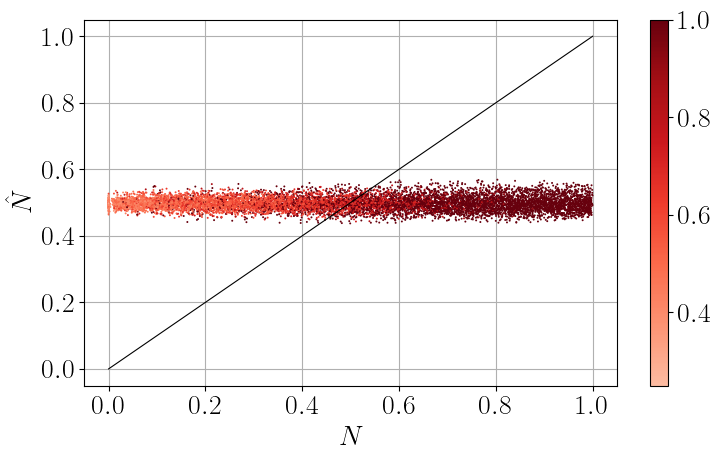

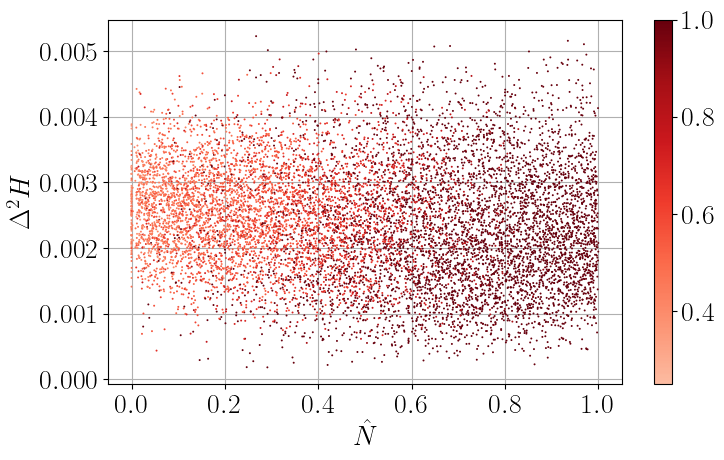

In [65]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_1, n_meas_1, n_layers_1))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))


cmap_name = "Reds"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_1 = sum(np.abs(labels_test - expecs_test_1)**2)/n_test
print("\nError:", sum_err_test_1)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 2 copies

In [90]:
n_copies_2 = 2
n_layers_2 = 2
n_tot_2 = n_inp*n_copies_2
n_meas_2 = n_inp*n_copies_2

# x0_2 = prev_to_next_ansatz(pars_1, n_tot_1, n_meas_1, n_layers_1, n_tot_2, n_meas_2, n_layers_2, subsval=0)
x0_2 = concatenate([normal(pi/2, 0.1, (3*n_tot_2 - 1)*n_layers_2 + 2*n_tot_2), normal(0, 1e-2, 2**n_meas_2)])

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_2, n_meas_2, n_layers_2) + info + "-pars"

In [125]:
w_ls = 1e0
w_var = 1e-4
n_shots = 5000

# x0_2 = array(pars_2)
fvals_2 = []#list(fvals_2)

parallel = True
method = "Cobyla"
options = {"maxiter": int(5000)}#, "maxfun": int(1e10)}#

time_start_2 = time()
fvals_2, result_2 = train_shots(dms_train, labels_train, n_layers=n_layers_2, n_shots=n_shots, method=method, 
                                n_copies=n_copies_2, n_meas=n_meas_2, w_ls=w_ls, w_var=w_var, 
                                options=options, x0=x0_2, save_data=False, file_name=file_name, fvals=fvals_2, parallel=parallel)

time_finish_2 = time() - time_start_2
print("\n\nFinished in", time_finish_2)
print("Cost:", result_2.fun)
print(result_2.message)
pars_2 = result_2.x

		Iteration: 1493 | Function value: 3.343220111

Finished in 179.43410229682922
Cost: 3.3432201114953717
Optimization terminated successfully.


In [127]:
expecs_train_2, disps_train_2 = aux_info(dms_train, labels_train, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)
expecs_test_2, disps_test_2 = aux_info(dms_test, labels_test, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)

n_inp: 2 | n_copies: 2 | n_meas: 4 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.0032615865445007955


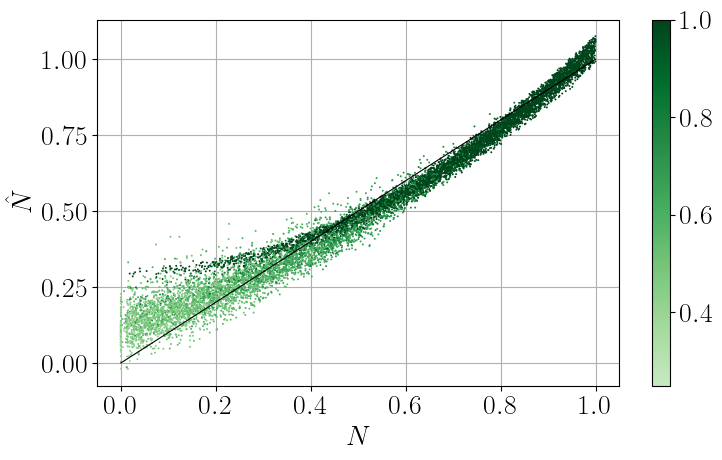

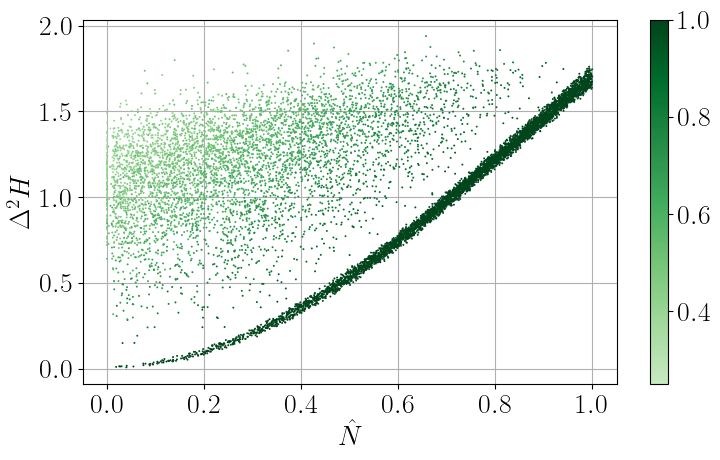

In [128]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_2, n_meas_2, n_layers_2))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Greens"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_2 = sum(np.abs(labels_test - expecs_test_2)**2)/n_test
print("\nError:", sum_err_test_2)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_2, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

#### 3 copies

In [137]:
n_copies_3 = 3
n_layers_3 = 2
n_tot_3 = n_inp*n_copies_3
n_meas_3 = n_inp*n_copies_3

x0_3 = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_3, n_meas_3, n_layers_3, subsval=0)

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_3, n_meas_3, n_layers_3) + info + "-pars"

In [138]:
path = "/home/kardashin/Work/QPE/Results/Entanglement/Shots/"
file_info = "c=%d-m=%d=l=%d-s=%d-w_ls=%f-w_var=%f-T=%d" %(n_copies_3, n_meas_3, n_layers_3, n_shots, w_ls, w_var, len(labels_train))
file_info += "-ent_rand_mixed"
file_name = path + file_info
file_name

'/home/kardashin/Work/QPE/Results/Entanglement/Shots/c=3-m=6=l=2-s=5000-w_ls=1.000000-w_var=0.000100-T=1000-ent_rand_mixed'

In [139]:
w_ls = 1e0
w_var = 1e-4
n_shots = 5000

# x0_3 = array(pars_3)
fvals_3 = []#list(fvals_3)

parallel = True
method = "Cobyla"
options = {"maxiter": int(10000)}#, "maxfun": int(1e10)}#

time_start_3 = time()
fvals_3, result_3 = train_shots(dms_train, labels_train, n_layers=n_layers_3, n_shots=n_shots, method=method, 
                                n_copies=n_copies_3, n_meas=n_meas_3, w_ls=w_ls, w_var=w_var, 
                                options=options, x0=x0_3, save_data=True, file_name=file_name, fvals=fvals_3, parallel=parallel)

time_finish_3 = time() - time_start_3
print("\n\nFinished in", time_finish_3)
print("Cost:", result_3.fun)
print(result_3.message)
pars_3 = result_3.x

		Iteration: 1012 | Function value: 3.029524829

Finished in 360.9938578605652
Cost: 3.029524820029184
Optimization terminated successfully.


In [140]:
expecs_train_3, disps_train_3 = aux_info(dms_train, labels_train, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)
expecs_test_3, disps_test_3 = aux_info(dms_test, labels_test, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)

n_inp: 2 | n_copies: 3 | n_meas: 6 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 

Error: 0.002951736008238137


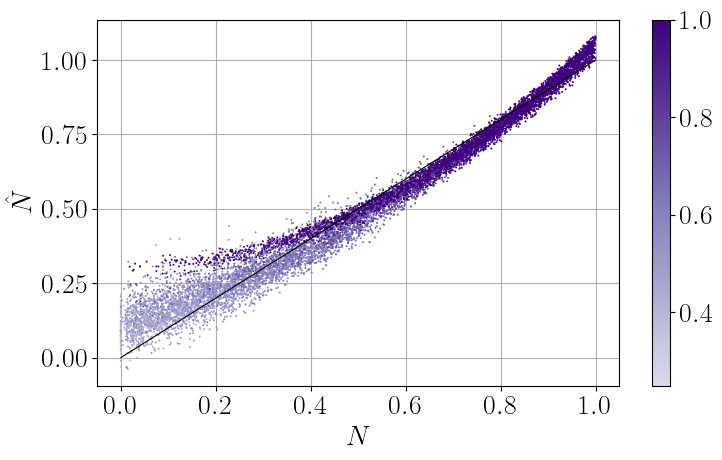

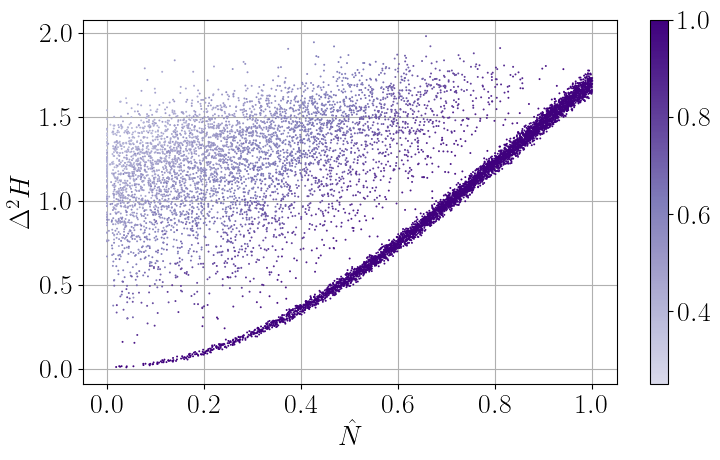

In [141]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_3, n_meas_3, n_layers_3))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Purples"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_3 = sum(np.abs(labels_test - expecs_test_3)**2)/n_test
print("\nError:", sum_err_test_3)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_3, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_3, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()

In [142]:
path = "/home/kardashin/Work/QPE/Results/Entanglement/Shots/"
file_info = "c=%d-m=%d=l=%d-s=%d-w_ls=%f-w_var=%f-T=%d" %(n_copies_3, n_meas_3, n_layers_3, n_shots, w_ls, w_var, len(labels_train))
file_info += "-ent_rand_mixed"
np.save(path + file_info + "-result", result_3)
np.save(path + file_info + "-pars", result_3.x)
np.save(path + file_info + "-fvals", fvals_3)
np.save(path + file_info + "-expecs_test", expecs_test_3)
np.save(path + file_info + "-disps_test", disps_test_3)

#### 4 copies

In [161]:
n_copies_4 = 4
n_layers_4 = 2
n_tot_4 = n_inp*n_copies_4
n_meas_4 = n_inp*n_copies_4

x0_4 = prev_to_next_ansatz(pars_3, n_tot_3, n_meas_3, n_layers_3, n_tot_4, n_meas_4, n_layers_4, subsval=0)

file_name = path + "c=%d-m=%d-l=%d-" %(n_copies_4, n_meas_4, n_layers_4) + info + "-pars"

In [162]:
w_ls = 1e0
w_var = 1e-4
n_shots = 10000

# x0_4 = array(pars_4)
fvals_4 = []#list(fvals_4)

parallel = True
method = "Cobyla"
options = {"maxiter": int(10000)}#, "maxfun": int(1e10)}#

time_start_4 = time()
fvals_4, result_4 = train_shots(dms_train, labels_train, n_layers=n_layers_4, n_shots=n_shots, method=method, 
                                n_copies=n_copies_4, n_meas=n_meas_4, w_ls=w_ls, w_var=w_var, 
                                options=options, x0=x0_4, save_data=False, file_name=file_name, fvals=fvals_4, parallel=parallel)

time_finish_4 = time() - time_start_4
print("\n\nFinished in", time_finish_4)
print("Cost:", result_4.fun)
print(result_4.message)
pars_4 = result_4.x

		Iteration: 8131 | Function value: 2.019714323

Finished in 36166.99120283127
Cost: 2.0197143200124907
Optimization terminated successfully.


In [ ]:
expecs_train_4, disps_train_4 = aux_info(dms_train, labels_train, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)
expecs_test_4, disps_test_4 = aux_info(dms_test, labels_test, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)

In [ ]:
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_4, n_meas_4, n_layers_4))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

cmap_name = "Blues"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test_4 = sum(np.abs(labels_test - expecs_test_4)**2)/n_test
print("\nError:", sum_err_test_4)

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-pred-test-fin.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$\hat{N}$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-random_mixed-qbq-var-test-fin.pdf", bbox_inches='tight')
plt.show()